# Purpose:
- Calculate z-drift from multi-plane imaging data
    - Multiple configurations: 1x8, 2x4, and 4x2
- Compare the results across depths
- Also with x-y motion
- To check if online motion correction with the mean of all planes is good enough
- Requires the depth_estimation_module from brain_observatory_qc
    - Also from_lims and allensdk

In [3]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims

save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')

In [27]:
def get_depth_region_from_db(oeid):
    from visual_behavior import database as db
    query = '''
    SELECT oe.id, st.acronym, oe.calculated_depth, imd.depth
    FROM ophys_experiments oe
    JOIN structures st ON st.id = oe.targeted_structure_id
    JOIN imaging_depths imd ON imd.id = oe.imaging_depth_id
    WHERE oe.id = {}
    '''.format(oeid)
    lims_results = db.lims_query(query)
    return lims_results.depth.values[0], lims_results.acronym.values[0]


def get_zdrift_results(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
        import h5py
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

## One example from 1x8 imaging data
- mouseID: 704576, session_id: 1330132892 (acquired 02/12/2024)


In [5]:
osid = 1330132892
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values


In [11]:

matched_plane_indices, corrcoef, segment_reg_imgs, \
        ref_oeid, ref_zstack_crop, rigid_tmat_list, translation_shift_list, ops = \
            dem.get_experiment_zdrift(oeids[0], ref_oeid=oeids[0], save_dir=save_dir)

# Select examples

In [2]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)

c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\behavior_project_cache\tables\util\prior_exposure_processing.py:165: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  counts = df.groupby(['mouse_id'])['to'].apply(cumsum)


In [5]:
table.project_code.unique()

array(['VisualBehaviorMultiscope', 'LearningmFISHDevelopment', 'U01BFCT',
       'OpenScopeDendriteCoupling', 'VisualBehavior',
       'VisBIntTestDatacube', 'VisualBehaviorTask1B',
       'MultiscopeSignalNoise', 'omFISHRbp4Meso', 'LearningmFISHTask1A',
       'TaskTrainedNetworksMultiscope', 'omFISHGad2Meso',
       'VisualBehaviorMultiscope4areasx2d', 'omFISHSstMeso',
       'VipAxonalV1Phase1', 'MesoscopeDevelopment', 'omFISHCux2Meso',
       'VisualBehaviorIntegrationTest', 'VisualBehaviorDevelopment'],
      dtype=object)

In [7]:
table.query('project_code == "LearningmFISHTask1A"').targeted_structure.unique()

array(['VISp', 'VISam', 'VISal', 'VISl'], dtype=object)

In [10]:
table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISl"').mouse_id.unique()

array(['639224', '612764', '646883', '633532', '636496', '616502',
       '617911', '616505', '608368', '624942', '603892', '629294'],
      dtype=object)

In [11]:
mids_config_4x2 = table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISl"').mouse_id.unique()


In [13]:
np.setdiff1d(table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISam"').mouse_id.unique(),
                mids_config_4x2)

array(['648606', '662253', '662491', '671833', '677594', '681417',
       '681721', '690308', '693545', '700387', '701050', '703340'],
      dtype=object)

In [14]:
mids_config_2x4 = np.setdiff1d(table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISam"').mouse_id.unique(),
                            mids_config_4x2)

In [4]:
lamf_table = table.query('project_code == "LearningmFISHTask1A"')
lamf_table.groupby('mouse_id').apply(lambda x: len(x.targeted_structure.unique()))

mouse_id
603892    4
608368    4
612764    4
616502    4
616505    4
617911    4
624942    4
629294    4
633532    4
636496    4
639224    4
646883    4
648606    2
662253    2
662491    2
671833    2
677594    2
681417    2
681721    2
690308    2
693545    2
700387    2
701050    2
703340    2
704576    1
710343    1
711414    1
dtype: int64

In [5]:
lamf_table.columns

Index(['equipment_name', 'donor_id', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'foraging_id',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set'],
      dtype='object')

In [48]:
lamf_table.session_type.unique()

array(['TRAINING_1_gratings', 'TRAINING_0_gratings_autorewards_15min',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'OPHYS_1_images_A', 'OPHYS_4_images_B', 'OPHYS_6_images_B',
       'TRAINING_5_images_A_handoff_ready'], dtype=object)

In [49]:
num_targeted_structure = lamf_table.groupby('mouse_id').apply(lambda x: len(x.targeted_structure.unique()))

min_num_sessions = 5

mids_config_4x2 = num_targeted_structure[num_targeted_structure == 4].index.values
num_sessions_within_mids = lamf_table[lamf_table.mouse_id.isin(mids_config_4x2)].groupby('mouse_id').apply(lambda x: len(x[~x.session_type.str.contains('TRAINING_0_')].ophys_session_id.unique()))
mids_config_4x2_final = num_sessions_within_mids[num_sessions_within_mids > min_num_sessions].index.values[-5:]

mids_config_2x4 = num_targeted_structure[num_targeted_structure == 2].index.values
num_sessions_within_mids = lamf_table[lamf_table.mouse_id.isin(mids_config_2x4)].groupby('mouse_id').apply(lambda x: len(x[~x.session_type.str.contains('TRAINING_0_')].ophys_session_id.unique()))
mids_config_2x4_final = num_sessions_within_mids[num_sessions_within_mids > min_num_sessions].index.values[-5:]

mids_config_1x8 = num_targeted_structure[num_targeted_structure == 1].index.values
num_sessions_within_mids = lamf_table[lamf_table.mouse_id.isin(mids_config_1x8)].groupby('mouse_id').apply(lambda x: len(x[~x.session_type.str.contains('TRAINING_0_')].ophys_session_id.unique()))
mids_config_1x8_final = num_sessions_within_mids[num_sessions_within_mids > min_num_sessions].index.values

print(f'{len(mids_config_4x2_final)} mice from 4x2')
print(f'{len(mids_config_2x4_final)} mice from 2x4')
print(f'{len(mids_config_1x8_final)} mice from 1x8')


5 mice from 4x2
5 mice from 2x4
3 mice from 1x8


In [58]:
# select random 3 sessions from 5 mice for each configuration
# - 3 mice for 1x8
num_selection = 3
multiplane_zdrift_osids = pd.DataFrame(columns=['mouse_id', 'ophys_session_id', 'config'])
select_session_type_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]
for mid in mids_config_4x2_final:
    temp_table = select_session_type_table[select_session_type_table.mouse_id == mid]
    osids = np.random.choice(temp_table.ophys_session_id.unique(), num_selection, replace=False)
    for osid in osids:
        temp_df = pd.DataFrame({'mouse_id': mid, 'ophys_session_id': osid, 'config': '4x2',
                                'session_type': lamf_table.query('ophys_session_id == @osid').session_type.unique()},
                                index=[0])
        multiplane_zdrift_osids = pd.concat([multiplane_zdrift_osids, temp_df], ignore_index=True)
for mid in mids_config_2x4_final:
    temp_table = select_session_type_table[select_session_type_table.mouse_id == mid]
    osids = np.random.choice(temp_table.ophys_session_id.unique(), num_selection, replace=False)
    for osid in osids:
        temp_df = pd.DataFrame({'mouse_id': mid, 'ophys_session_id': osid, 'config': '2x4',
                                'session_type': lamf_table.query('ophys_session_id == @osid').session_type.unique()},
                                index=[0])
        multiplane_zdrift_osids = pd.concat([multiplane_zdrift_osids, temp_df], ignore_index=True)
for mid in mids_config_1x8_final:
    temp_table = select_session_type_table[select_session_type_table.mouse_id == mid]
    osids = np.random.choice(temp_table.ophys_session_id.unique(), num_selection, replace=False)
    for osid in osids:
        temp_df = pd.DataFrame({'mouse_id': mid, 'ophys_session_id': osid, 'config': '1x8',
                                'session_type': lamf_table.query('ophys_session_id == @osid').session_type.unique()},
                                index=[0])
        multiplane_zdrift_osids = pd.concat([multiplane_zdrift_osids, temp_df], ignore_index=True)
assert len(multiplane_zdrift_osids) == len(multiplane_zdrift_osids.ophys_session_id.unique())
multiplane_zdrift_osids

,mouse_id,ophys_session_id,config,session_type
0,629294,1190857914,4x2,TRAINING_3_images_A_10uL_reward
1,629294,1192836327,4x2,OPHYS_4_images_B
2,629294,1192643624,4x2,OPHYS_1_images_A
3,633532,1198731689,4x2,TRAINING_1_gratings
4,633532,1202354311,4x2,OPHYS_4_images_B
5,633532,1203356885,4x2,OPHYS_6_images_B
6,636496,1212181327,4x2,TRAINING_5_images_A_handoff_ready
7,636496,1212491869,4x2,OPHYS_1_images_A
8,636496,1208615694,4x2,TRAINING_1_gratings
9,639224,1217503944,4x2,TRAINING_3_images_A_10uL_reward


In [59]:
# save this dataframe
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids.to_csv(save_dir / 'multiplane_zdrift_osids_240223.csv', index=False)

# Data analysis

In [5]:
load_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids = pd.read_csv(load_dir / 'multiplane_zdrift_osids_240223.csv')
multiplane_zdrift_osids.head()

,mouse_id,ophys_session_id,config,session_type
0,629294,1190857914,4x2,TRAINING_3_images_A_10uL_reward
1,629294,1192836327,4x2,OPHYS_4_images_B
2,629294,1192643624,4x2,OPHYS_1_images_A
3,633532,1198731689,4x2,TRAINING_1_gratings
4,633532,1202354311,4x2,OPHYS_4_images_B


In [62]:
multiplane_zdrift_osids.config.unique()

array(['4x2', '2x4', '1x8'], dtype=object)

### 1x8 first

In [72]:
lamf_table.columns

Index(['equipment_name', 'donor_id', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'foraging_id',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set'],
      dtype='object')

In [7]:
temp_table = multiplane_zdrift_osids.query('config == "1x8"')
osids = temp_table.ophys_session_id.unique()
osid = osids[0]
corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
assert len(np.where(np.array(corrcoef) < 0.7)[0]) == 0


Text(0.5, 1.0, 'ophys_session_id 1326968345')

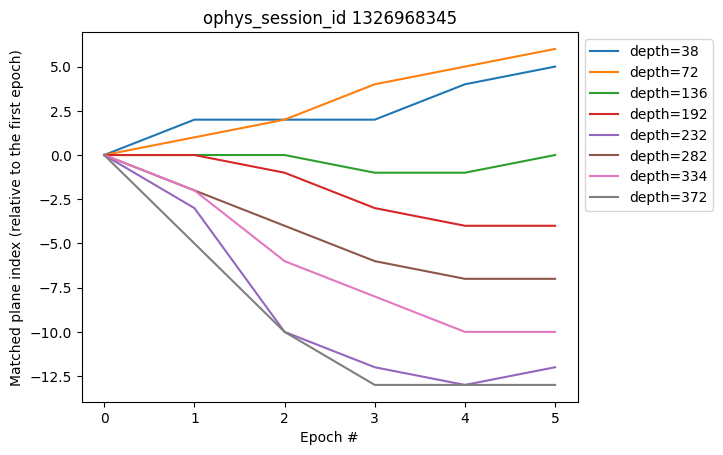

In [8]:
depth = []
for oeid in oeids:
    depth.append(lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0])
depth_order = np.argsort(depth)
fig, ax = plt.subplots()
for doi in depth_order:
    ax.plot([mpi-matched_plane_indices[doi][0] for mpi in matched_plane_indices[doi]], label=f'depth={depth[doi]}')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Epoch #')
ax.set_ylabel('Matched plane index (relative to the first epoch)')
ax.set_title(f'ophys_session_id {osid}')

### 4x2 and 2x4

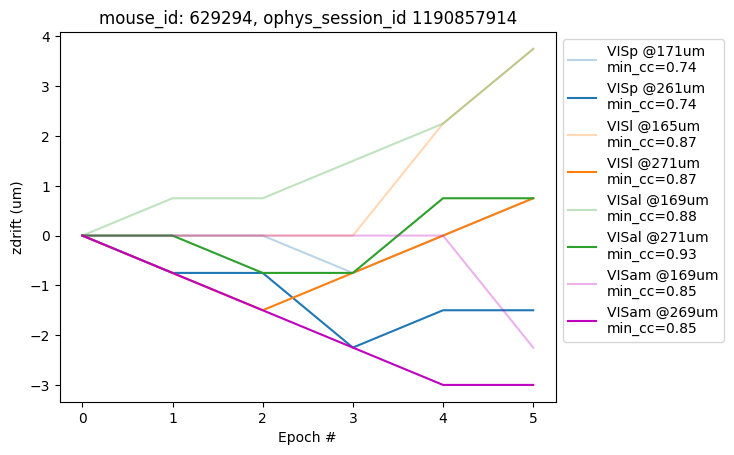

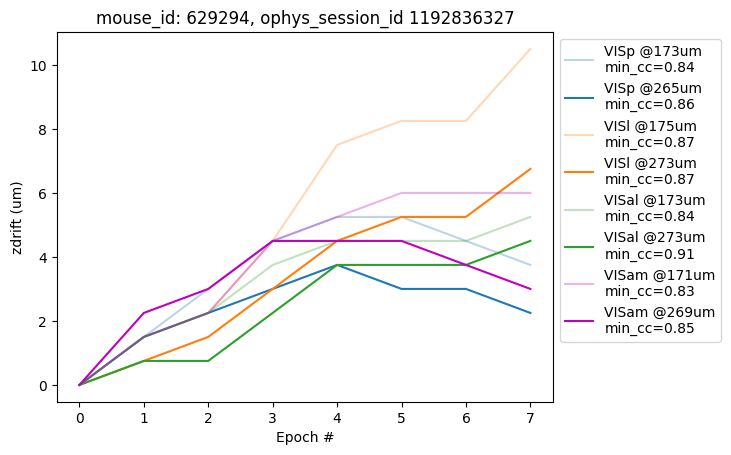

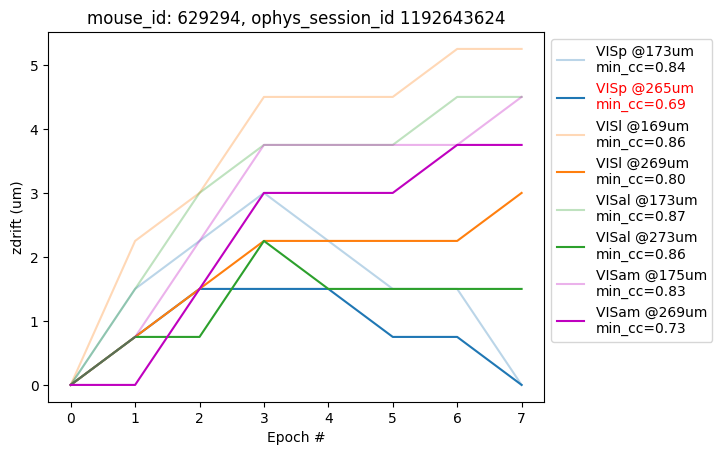

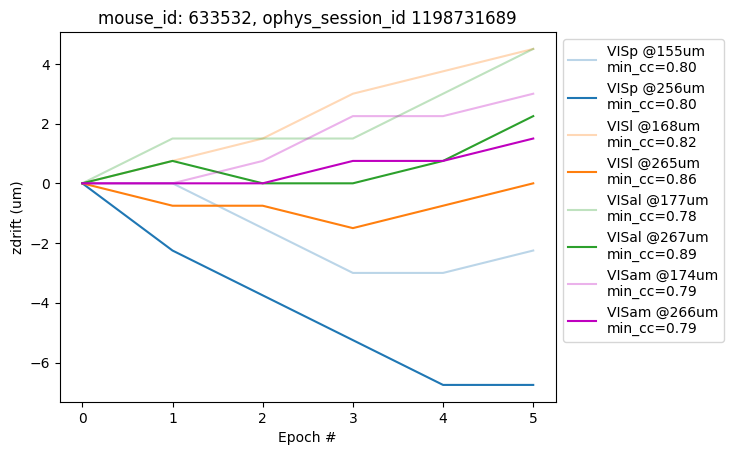

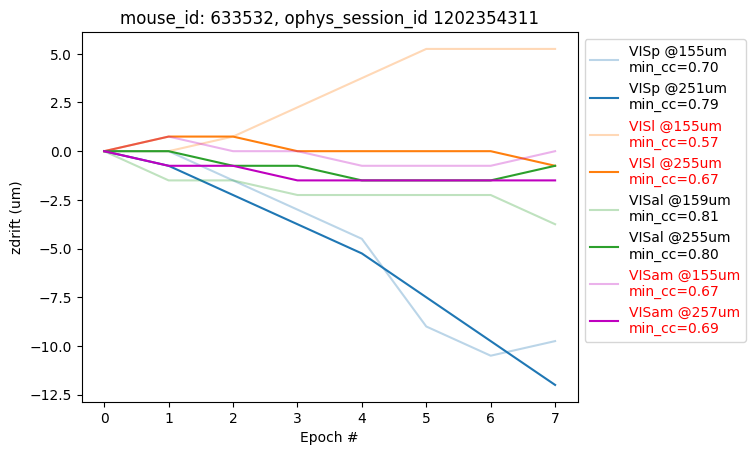

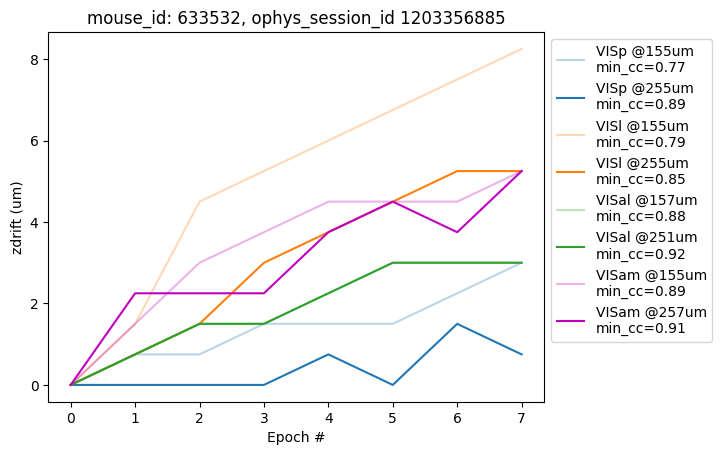

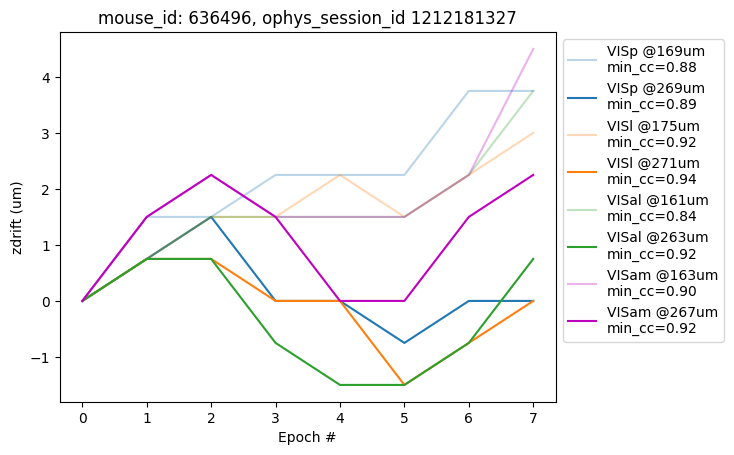

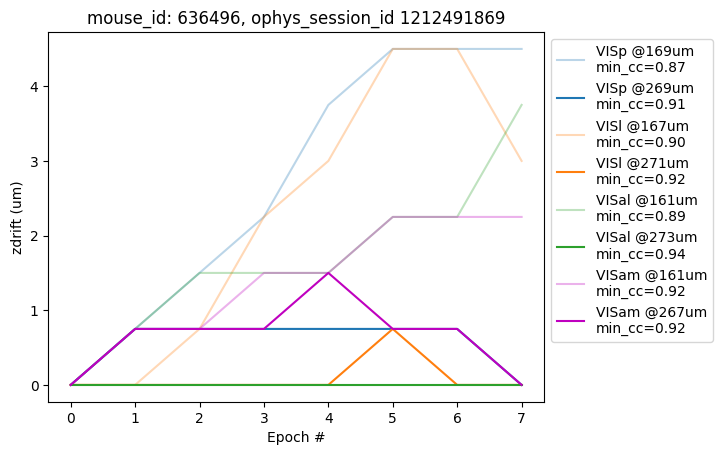

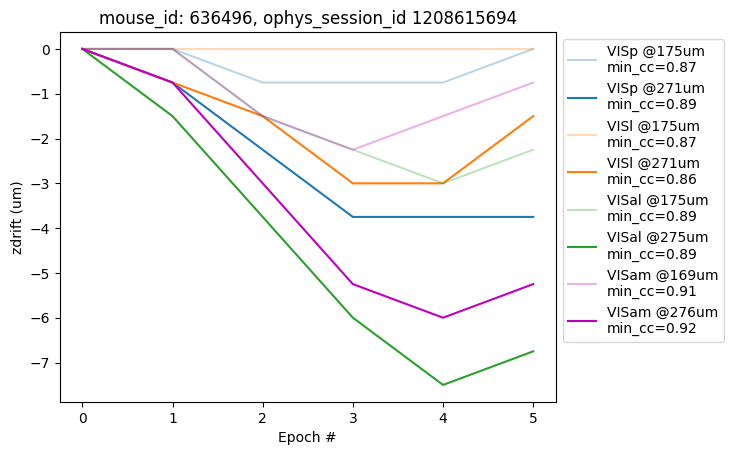

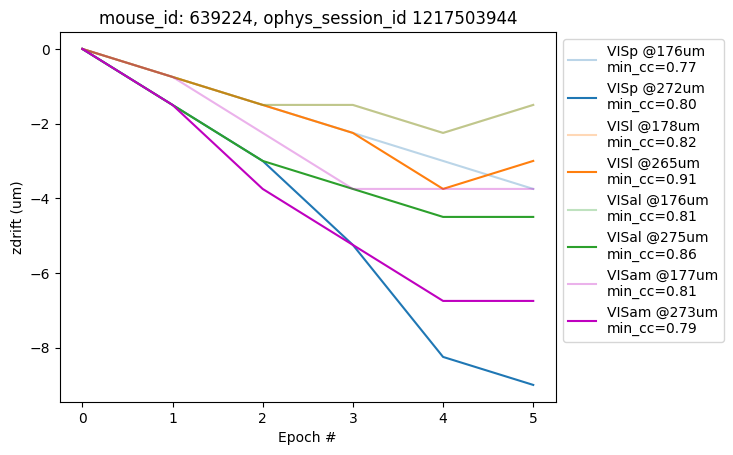

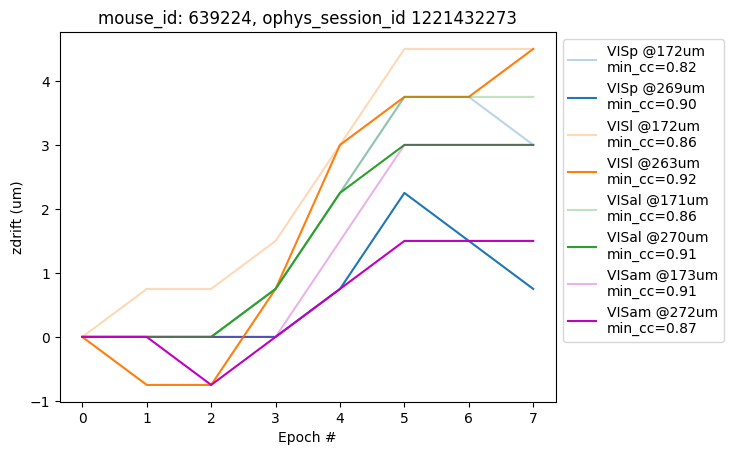

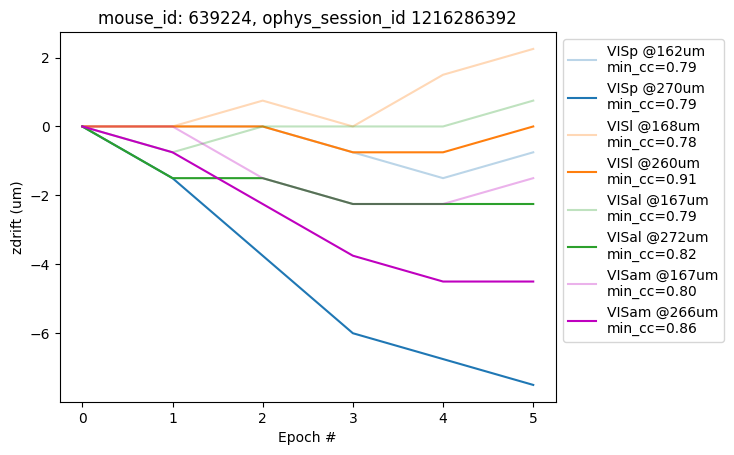

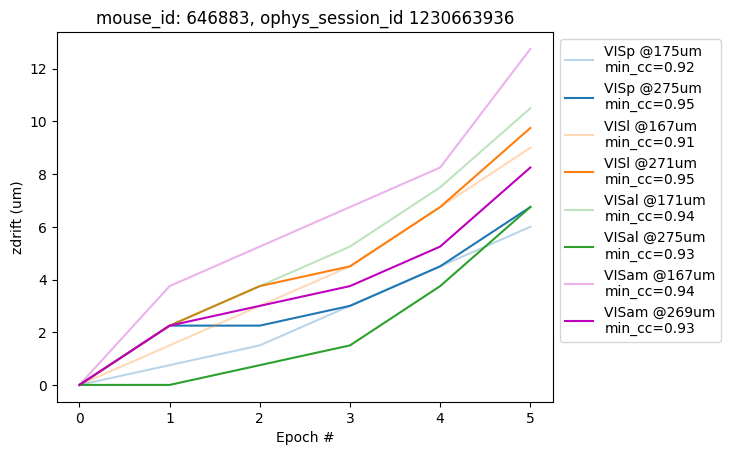

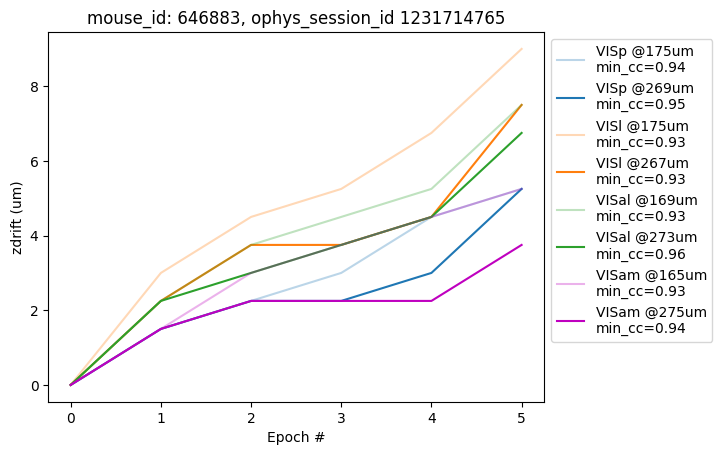

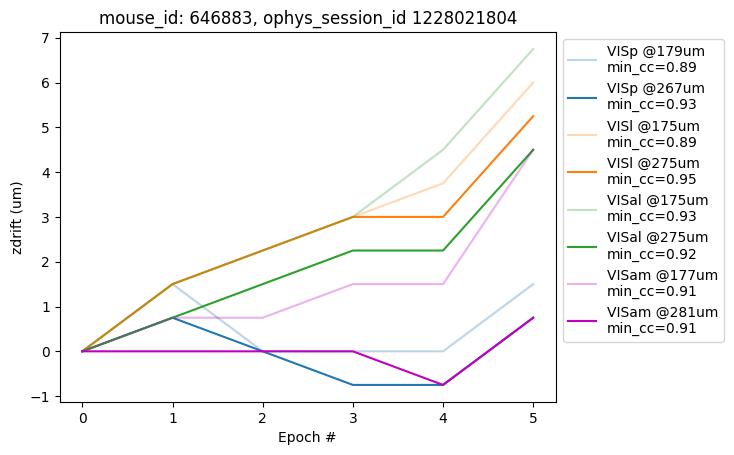

In [154]:
temp_table = multiplane_zdrift_osids.query('config == "4x2"')
osids = temp_table.ophys_session_id.unique()
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]

    # get depth and region
    depth = []
    region = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
            current_region = lamf_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
        region.append(current_region)
    
    # order the table by region and depth
    region_order = ['VISp', 'VISl', 'VISal', 'VISam']
    temp_order_table = pd.DataFrame({'depth': depth, 'region': region, 'oeid': oeids,
                                    'matched_plane_indices': matched_plane_indices,
                                    'min_corrcoef': min_corrcoef})
    temp_order_table['region_order'] = temp_order_table.region.apply(lambda x: region_order.index(x))
    temp_order_table = temp_order_table.sort_values(by=['region_order', 'depth']).reset_index(drop=True)

    # plot
    colors = ['C0', 'C0', 'C1', 'C1', 'C2', 'C2', 'm', 'm']
    fig, ax = plt.subplots()
    for i, row in temp_order_table.iterrows():
        zdrift = np.array([mpi-row.matched_plane_indices[0] for mpi in row.matched_plane_indices]) * 0.75
        ax.plot(zdrift, color=colors[i], alpha=1-((i+1)%2)*0.7,
                label=f'{row.region} @{row.depth}um\nmin_cc={row.min_corrcoef:.2f}')
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    for i, text in enumerate(legend.get_texts()):
        if min_corrcoef_ordered[i] < 0.7:
            text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('zdrift (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')



C:\Users\jinho.kim\Github\visual_behavior_analysis\visual_behavior\database.py:729: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\jinho.kim\Github\visual_behavior_analysis\visual_behavior\database.py:729: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\jinho.kim\Github\visual_behavior_analysis\visual_behavior\database.py:729: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\jinho.kim\Github\visual_behavior_analysi

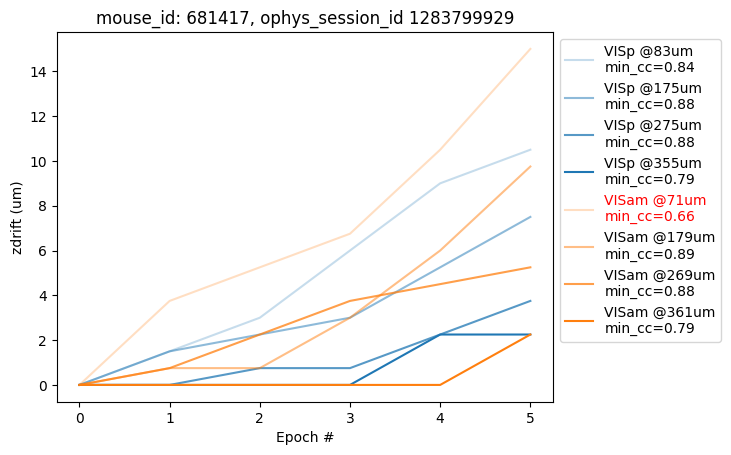

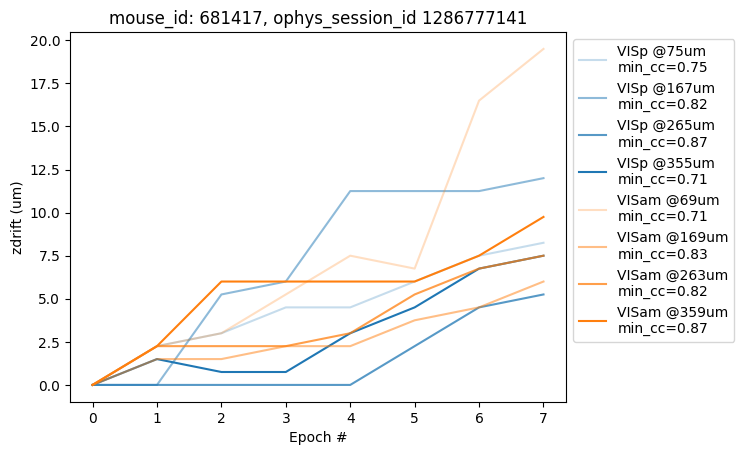

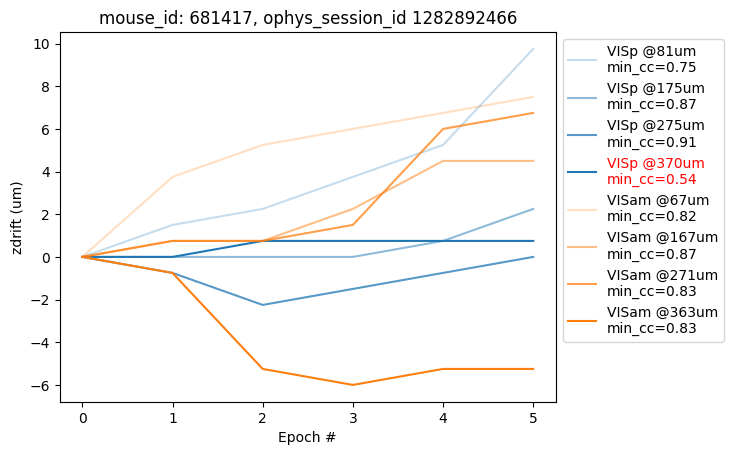

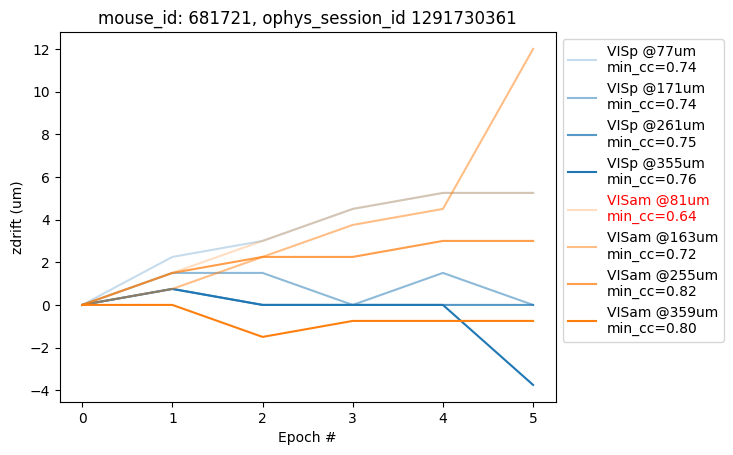

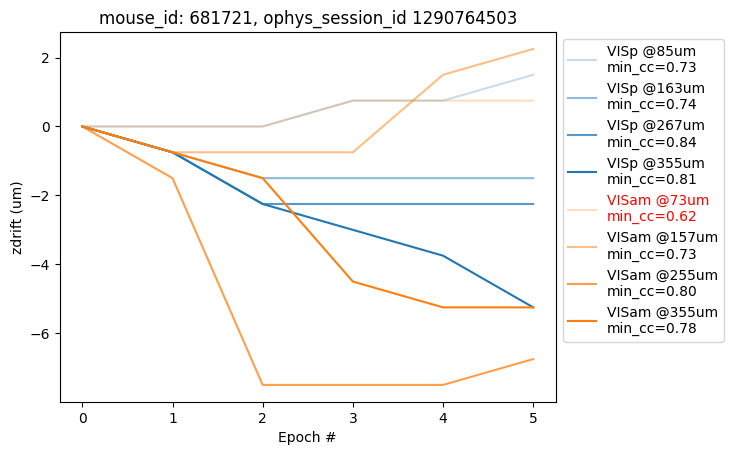

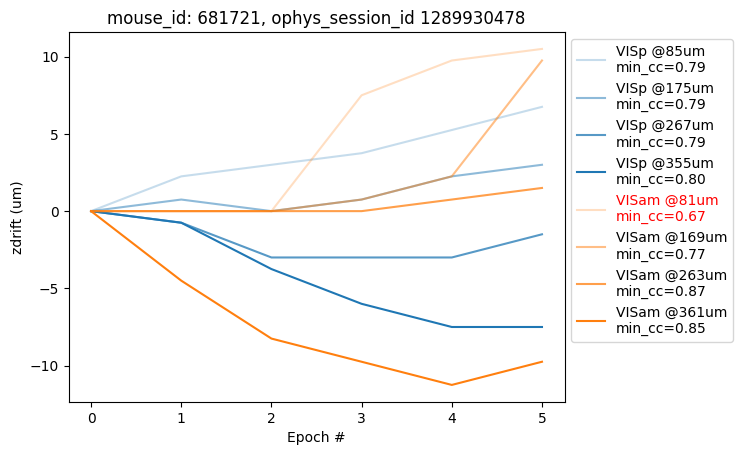

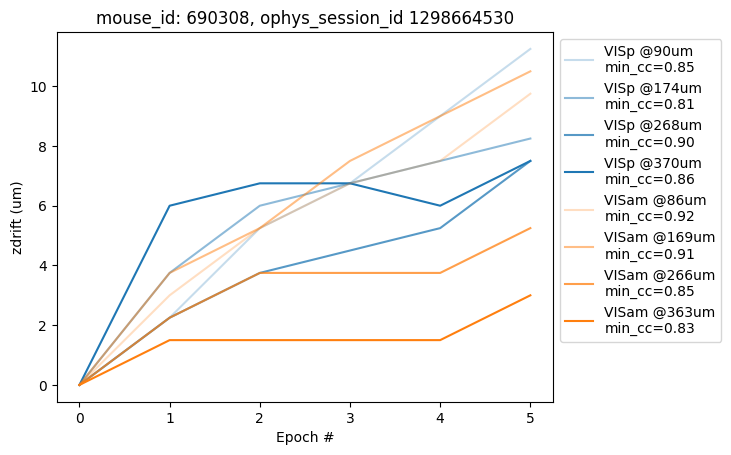

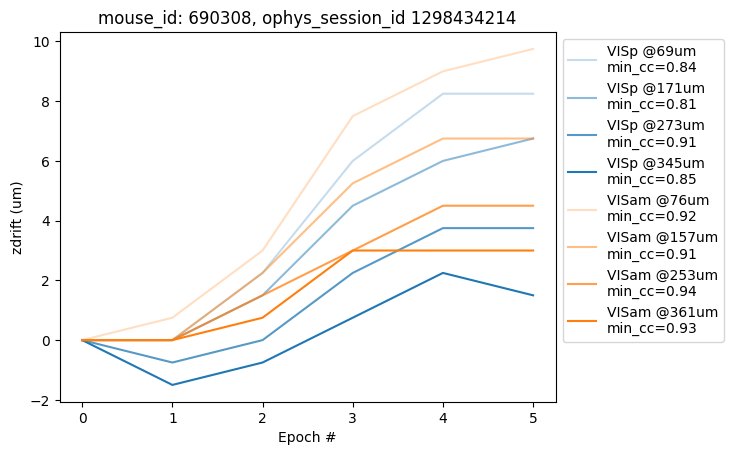

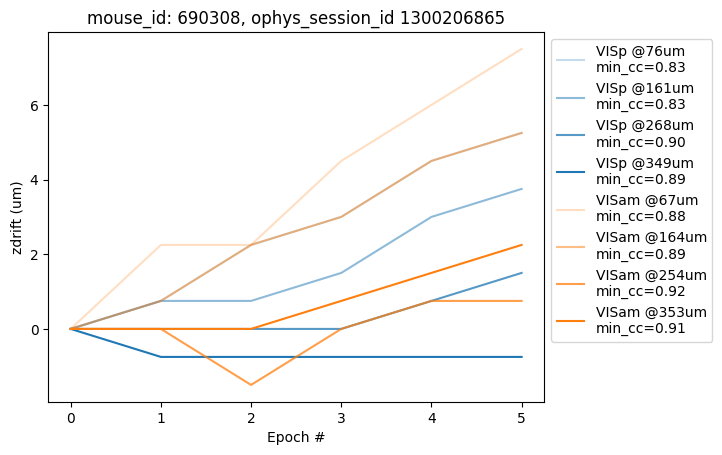

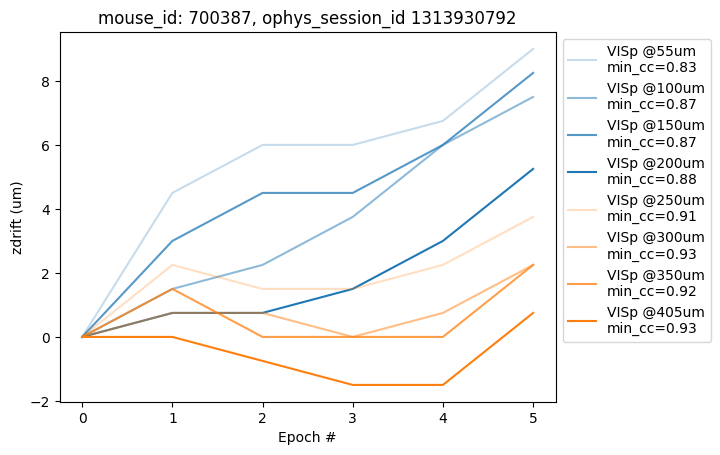

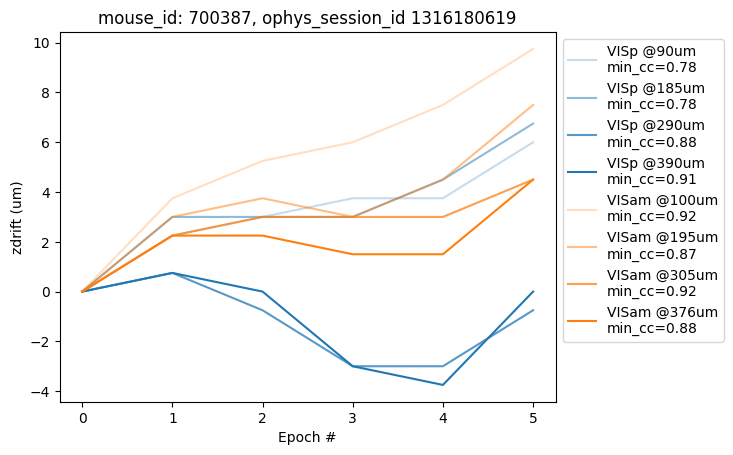

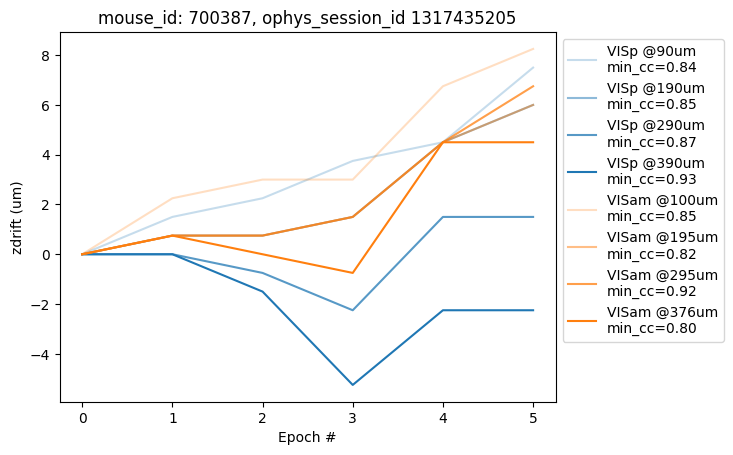

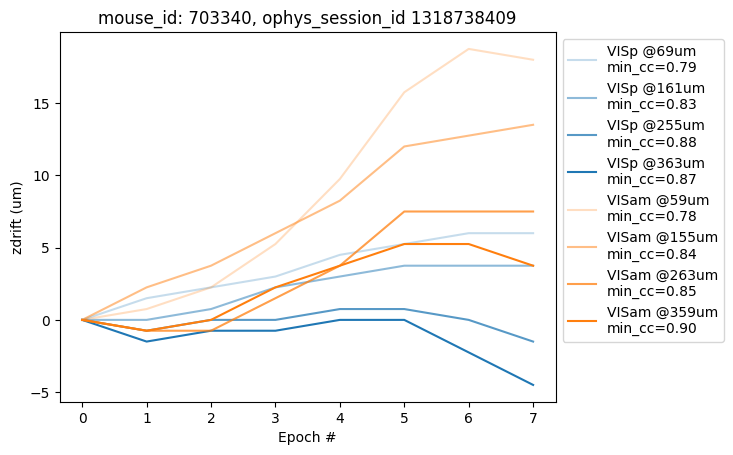

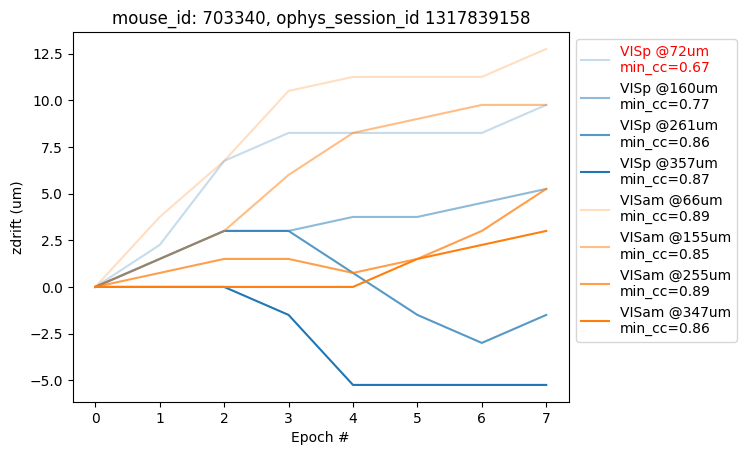

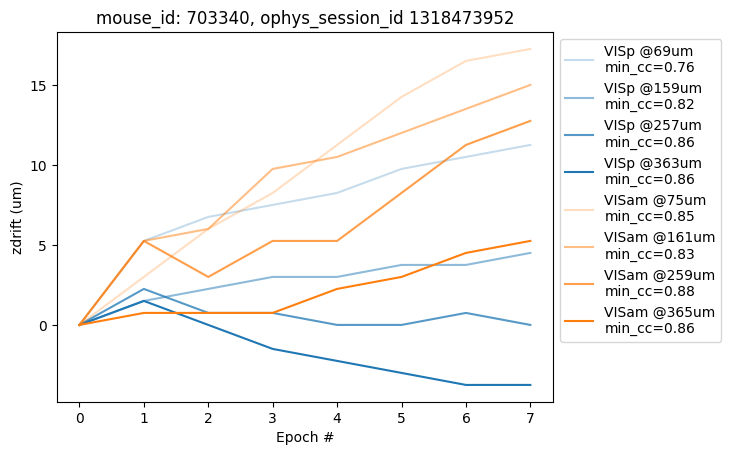

In [53]:
temp_table = multiplane_zdrift_osids.query('config == "2x4"')
osids = temp_table.ophys_session_id.unique()
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]

    # get depth and region
    depth = []
    region = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
            current_region = lamf_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
        region.append(current_region)
    
    # order the table by region and depth
    region_order = ['VISp', 'VISam']
    temp_order_table = pd.DataFrame({'depth': depth, 'region': region, 'oeid': oeids,
                                    'matched_plane_indices': matched_plane_indices,
                                    'min_corrcoef': min_corrcoef})
    temp_order_table['region_order'] = temp_order_table.region.apply(lambda x: region_order.index(x))
    temp_order_table = temp_order_table.sort_values(by=['region_order', 'depth']).reset_index(drop=True)

    # plot
    colors = ['C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C1']
    fig, ax = plt.subplots()
    for i, row in temp_order_table.iterrows():
        zdrift = np.array([mpi-row.matched_plane_indices[0] for mpi in row.matched_plane_indices]) * 0.75
        ax.plot(zdrift, color=colors[i], alpha=(i%4)*0.25+0.25,
                label=f'{row.region} @{row.depth}um\nmin_cc={row.min_corrcoef:.2f}')
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    for i, text in enumerate(legend.get_texts()):
        if min_corrcoef_ordered[i] < 0.7:
            text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('zdrift (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')


In [50]:
for i, row in temp_order_table.iterrows():
    print((i%4)*0.25+0.25)


0.25
0.5
0.75
1.0
0.25
0.5
0.75
1.0


In [31]:
temp_order_table

,depth,region,oeid,matched_plane_indices,min_corrcoef,region_order
0,83,VISp,1283950652,"[25, 27, 29, 33, 37, 39]",0.844667,0
1,175,VISp,1283950649,"[27, 29, 30, 31, 34, 37]",0.878051,0
2,275,VISp,1283950651,"[31, 31, 32, 32, 34, 36]",0.875906,0
3,355,VISp,1283950654,"[30, 30, 30, 30, 33, 33]",0.794383,0
4,71,VISam,1283950658,"[22, 27, 29, 31, 36, 42]",0.662107,1
5,179,VISam,1283950655,"[26, 27, 27, 30, 34, 39]",0.890020,1
6,269,VISam,1283950657,"[33, 34, 36, 38, 39, 40]",0.879859,1
7,361,VISam,1283950660,"[34, 34, 34, 34, 34, 37]",0.790763,1


In [21]:
osid = osids[0]
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
oeid = oeids[0]
lamf_table.query('ophys_experiment_id == @oeid')

,equipment_name,donor_id,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,foraging_id,cre_line,...,session_name,isi_experiment_id,imaging_depth,targeted_structure,published_at,date_of_acquisition,session_type,experience_level,passive,image_set
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
1283950655,MESO.2,1274324881,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,681417,Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg,"[Slc32a1-T2A-FlpO, Gad2-IRES-Cre]",M,82.0,bfb6d142-e317-414c-aebb-214e8f82d525,Gad2-IRES-Cre,...,20230718_681417_training3,1277589639,179,VISam,NaT,2023-07-18 16:55:21.391,TRAINING_3_images_A_10uL_reward,None,False,e


## Getting results from HPC run
- qc/2p_data/z_drift/scripts/multi_plane_zdrift_sbatch.py

In [169]:
load_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids = pd.read_csv(load_dir / 'multiplane_zdrift_osids_240223.csv')
multiplane_zdrift_osids.head()

,mouse_id,ophys_session_id,config,session_type
0,629294,1190857914,4x2,TRAINING_3_images_A_10uL_reward
1,629294,1192836327,4x2,OPHYS_4_images_B
2,629294,1192643624,4x2,OPHYS_1_images_A
3,633532,1198731689,4x2,TRAINING_1_gratings
4,633532,1202354311,4x2,OPHYS_4_images_B


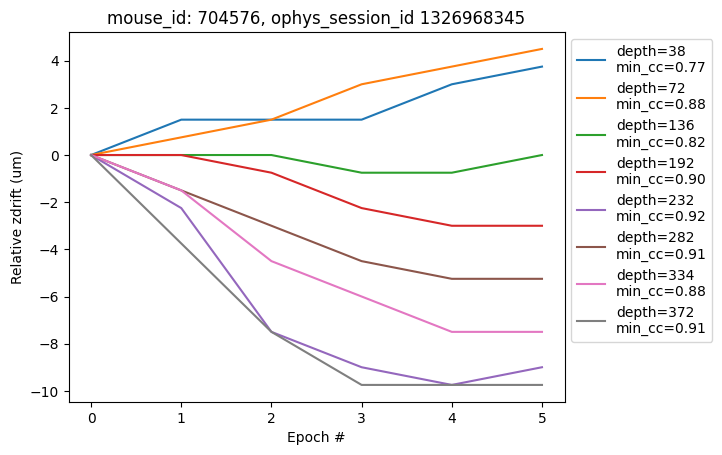

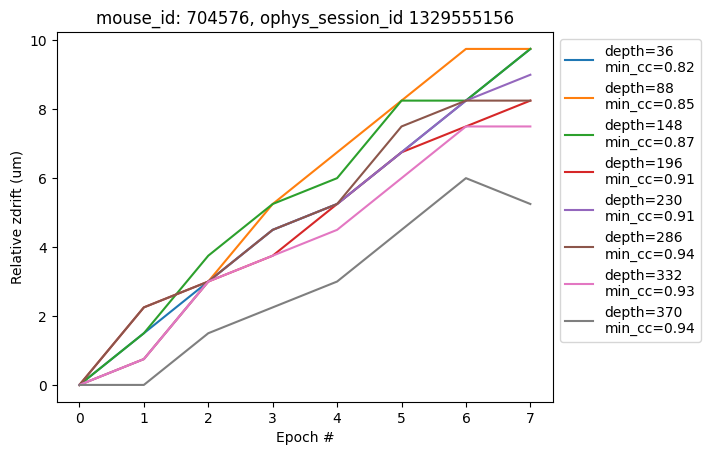

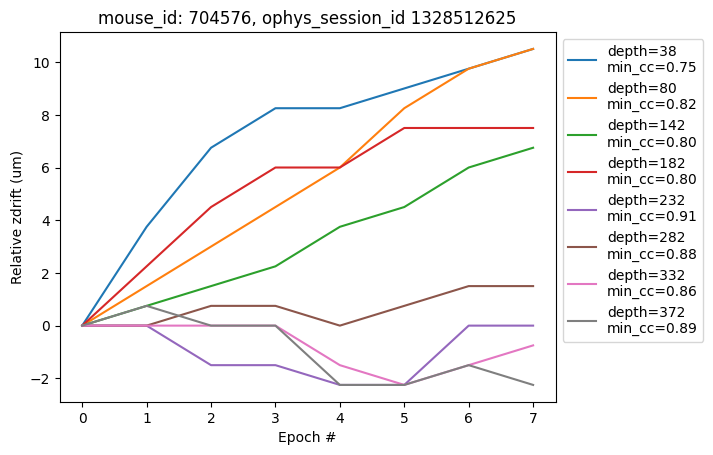

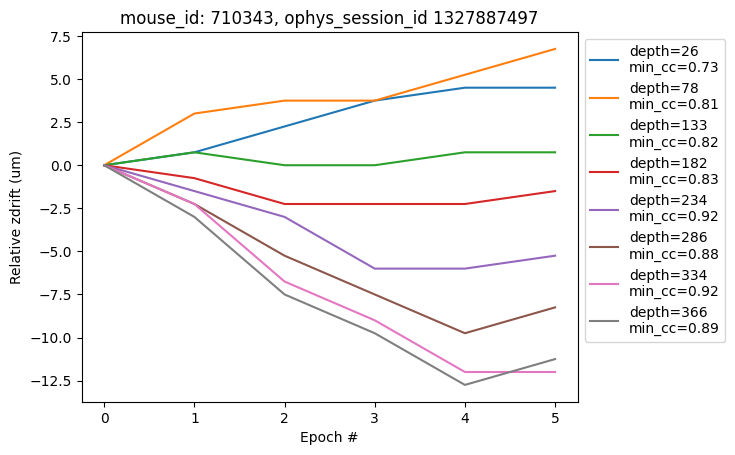

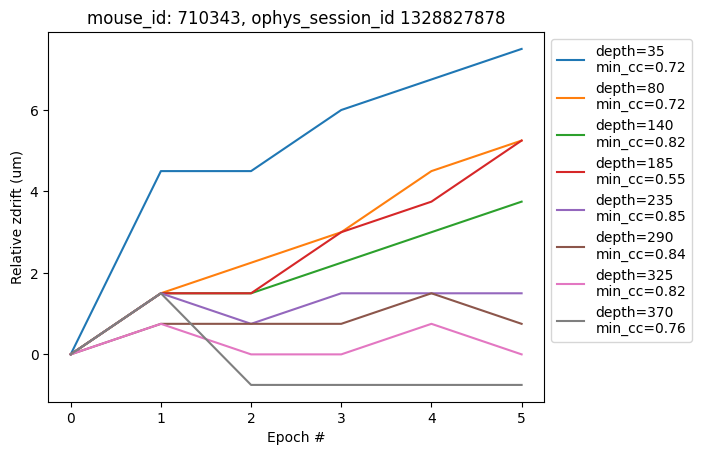

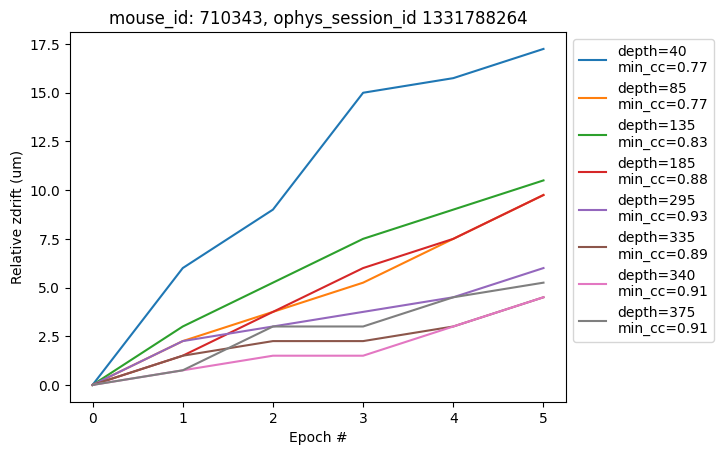

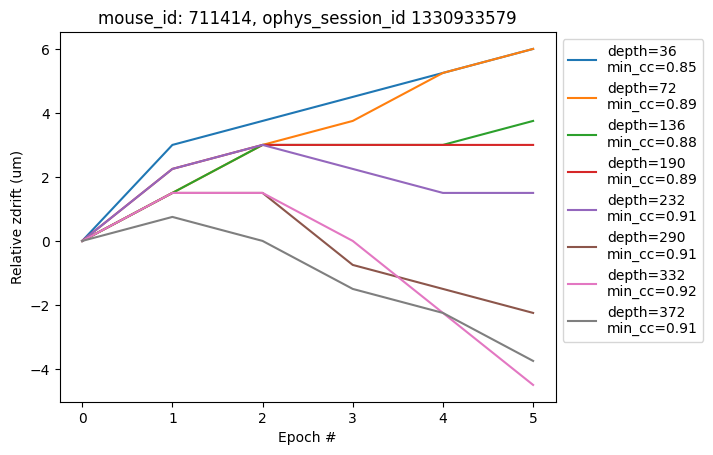

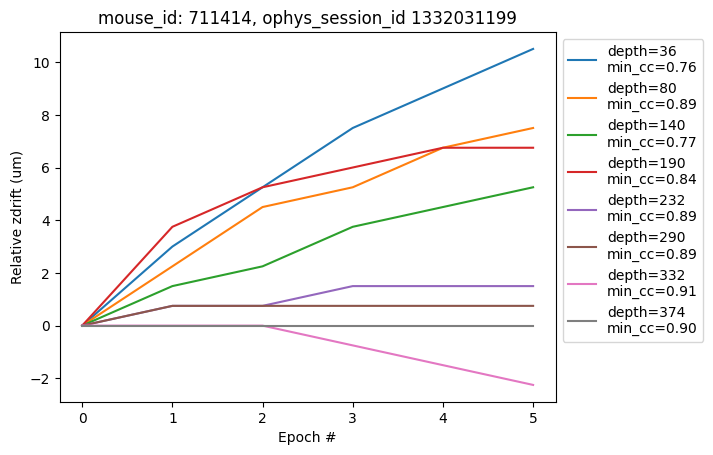

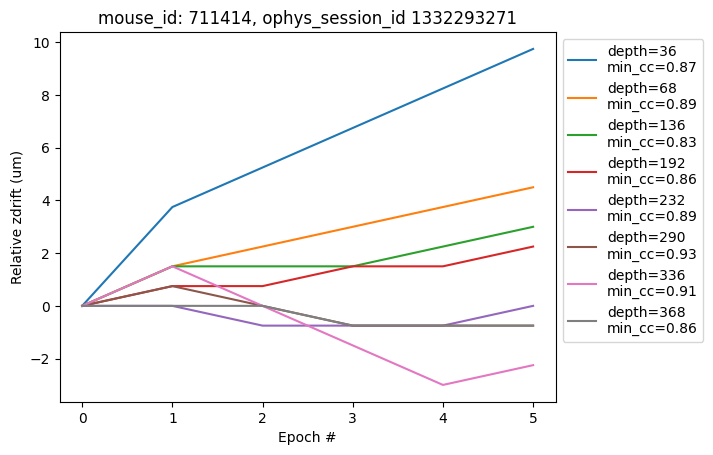

In [61]:
temp_table = multiplane_zdrift_osids.query('config == "1x8"')
osids = temp_table.ophys_session_id.unique()
local_zstack_interval = 0.75
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]
    # get depth
    depth = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
    depth_order = np.argsort(depth)
    fig, ax = plt.subplots()
    for doi in depth_order:
        zdrift = np.array([mpi-matched_plane_indices[doi][0] for mpi in matched_plane_indices[doi]]) * local_zstack_interval
        ax.plot(zdrift, label=f'depth={depth[doi]}\nmin_cc={min_corrcoef[doi]:.2f}')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    for doi, text in enumerate(legend.get_texts()):
        if min_corrcoef[doi] < 0.7:
            text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Relative zdrift (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')

In [70]:
# checking the session type (is any of them passive?)
osid = 1328512625
session_type = lamf_table.query('ophys_session_id == @osid').session_type.unique()
print(session_type)

['OPHYS_1_images_A']


# Interim summary
- z-drift is variable between depths and regions
    - The variance is also variable across sessions (even within a mouse)
- At least in 1x8 configuration
    - Total water consumption might be related to z-drift variation
    

# Next steps
- First, estimate the efficacy of online motion correction using global mean
- Calculate total water consumption / total run distance VS z-drift variation at the end / top2 vs bottom2 correlation
- Look at temporal dynamics of total water consumption / running distance compared to zdrift variation across epochs
- Focus on 1x8 for now


## Efficacy of online motion correction

# Error cases
- ophys_container_id issue

In [35]:
osid = 1317188386
from_lims.get_ophys_container_ids_for_ophys_session_id(osid) 

,ophys_container_id
0,1317488271
1,1317488268
2,1317488265
3,1317488280


In [42]:
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
osid = 1197680039
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
for oeid in oeids:
    matched_plane_indices, corrcoef, segment_reg_imgs, \
        ref_oeid, ref_zstack_crop, rigid_tmat_list, translation_shift_list, ops = \
            dem.get_experiment_zdrift(oeid, ref_oeid=oeid, save_dir=save_dir, rerun=True)


In [43]:
osid = 1300206865
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
oeids

array([1300329813, 1300329815, 1300329821, 1300329812, 1300329810,
       1300329819, 1300329818, 1300329816], dtype=int64)

In [45]:
oeid

1300329812

In [47]:
print(from_lims.get_session_h5_filepath(osid))

\\allen\programs\mindscope\production\learning\prod0\specimen_1287205163\ophys_session_1300206865\1300206865_20230928T111704.h5


In [44]:
for oeid in oeids:
    from_lims.get_dff_traces_filepath(oeid)

KeyError: 'filepath'

In [40]:
from importlib import reload
reload(dem)

<module 'brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module' from 'c:\\users\\jinho.kim\\github\\brain_observatory_qc\\brain_observatory_qc\\pipeline_dev\\scripts\\depth_estimation_module.py'>

In [34]:
oeid

1319312444

In [37]:
# read json file
import json
json_filepath = from_lims.get_platform_json_filepath(osid)
with open(json_filepath, 'r') as f:
    data = json.load(f)
data['rig_id']

In [42]:
reload(dem)
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
matched_plane_indices, corrcoef, segment_reg_imgs, \
    ref_oeid, ref_zstack_crop, rigid_tmat_list, translation_shift_list, ops = \
        dem.get_experiment_zdrift(oeid, ref_oeid=oeid, save_dir=save_dir, rerun=True)

In [30]:
print(from_lims.get_dff_traces_filepath(oeid).parent)

\\allen\programs\mindscope\production\learning\prod0\specimen_1302006161\ophys_session_1319182745\ophys_experiment_1319312444


In [26]:
for oeid in oeids:
    from_lims.get_general_info_for_ophys_experiment_id(oeid)

KeyError: 'specimen_storage_directory'